# Юдин Артём БВТ2101

In [2]:
# для обработки данных и отрисовки изображений
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# для обучения модели
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

# для предобработки текстового датасета
import re
import spacy
import nltk
from collections import Counter

# для отображения прогрессии
from tqdm import tqdm

tqdm.pandas()

from tqdm.auto import tqdm

2024-04-13 07:02:00,611	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [60]:
# параметры для обучения
epochs = 60
batch_size = 512
device = "cuda" if torch.cuda.is_available() else "cpu"

# языковые параметры
embedding_dim = 50
vocab_size = 40000
max_tokens = 100


# создание токенизатора и стоп-слов
tokenizator = spacy.load("en_core_web_lg")
stopwords = set(nltk.corpus.stopwords.words("english"))

In [ ]:
df = pd.read_csv(
    "/kaggle/input/word2vec-nlp-tutorial/labeledTrainData.tsv.zip", sep="\t"
)

Задачи обработки естественного языка требуют от нас предобработки текста для улучшения качества модели. Это включает себя:
+ удаление пунктуации и цифр
+ приведение всех слов к нижнему регистру и начальной форме для уменьшения размером словаря
+ удаление слов, которые несут мало смысла, но занимают места (стоп слова)

Все эти вещи в той или иной степени ухудшают качество модели. Напишем две функции для выполнения всех необходимых действий

In [6]:
def remove_stopwords(review, stopwords):
    return [token for token in review if token not in stopwords]


def preprocessing(review, stopwords):
    review = review.replace([",", "."], " ")  # убираем пунктуацию
    review_lower = review.lower()  # приводим к нижнему регистру
    removed_symbols = re.sub(
        r"[^a-z\s]+", " ", review_lower
    )  # убираем все символы, кроме букв и процессоров

    tokens = tokenizator(removed_symbols)  # разделяем слова по пробелам

    lemmas = [token.lemma_ for token in tokens]  # берём начальную форму слова

    return remove_stopwords(lemmas, stopwords)

Теперь посмотрим на наш токенизированный текст

In [7]:
df["preprocessed"] = df["review"].progress_apply(preprocessing)
df.head(5)

Pandas Apply:   0%|          | 0/25000 [00:00<?, ?it/s]

,id,sentiment,review,preprocessed
17423,6851_8,1,De Palma's technique had hit its high maturity...,"[de, palma, technique, hit, high, maturity, ti..."
14441,12088_2,0,"I read the reviews of this movie, and they wer...","[I, read, review, movie, , generally, pretty,..."
20743,11718_1,0,"It is incredible!! ..yes, someone before me wr...","[incredible, , yes, , someone, I, write, ti..."
3253,6529_3,0,This movie is funny and painful at the same ti...,"[movie, funny, painful, time, , , cinemagic,..."
7503,5918_1,0,Carl Panzram lived an amazing life and scribbl...,"[carl, panzram, live, amazing, life, scribble,..."


Теперь нам нужно создать общий словарь для перевода слов в индексы

In [ ]:
# берём все токенизированные предложения и вытаскиваем их из датафрейма
list_of_sentences = list(" ".join(x) for x in df["preprocessed"].tolist())

# обхединяем все слова из предложений вместе
all_words = " ".join(list_of_sentences)

# делаем подсчёт всех слов, чтобы потом отобрать самые часто встречающиеся
# брать редкие слова смысла нет, так как мы не обучим на них модель, но они
# будут генерировать случайный шум
count_words = Counter(all_words.split())

# создаём HashSet всех слов
vocab = set(item[0] for item in count_words.most_common(vocab_size))

# добавляем спец токены для неизв, начала-, конца строки и падинга
vocab |= {"<unk>", "<bos>", "<eos>", "<pad>"}

# преобразователь слов в индексы таблицы эмбедингов
word2ind = {word: ind for ind, word in enumerate(vocab)}

Теперь перейдём к последним 3 пунктам предобработки датасета:
+ индексирование - замена всех слов на их индексы для последующего использования матрицы эмбедингов
+ транкинг - обрезание слов слишком большой длины
+ падинг - добавление значения для выравнивания последовательностей

In [23]:
def indexing(tokens, word2ind=word2ind):
    return (
        [word2ind["<bos>"]]
        + [word2ind.get(x, word2ind["<unk>"]) for x in tokens]
        + [word2ind["<eos>"]]
    )


def truncing(tokens, max_tokens=max_tokens):
    return tokens[:max_tokens]


def padding(tokens, max_tokens=max_tokens + 2):
    return tokens + [word2ind["<pad>"]] * (max_tokens - len(tokens))


df["tokens"] = df["preprocessed"].progress_apply(indexing)
df["trunc"] = df["tokens"].progress_apply(truncing)
df["padded"] = df["trunc"].progress_apply(padding)

df.head(10)

Pandas Apply:   0%|          | 0/25000 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/25000 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/25000 [00:00<?, ?it/s]

,id,sentiment,review,preprocessed,tokens,trunc,padded
3130,3910_10,1,"So I'm at home, flipping channels one night, a...","[I, home, , flip, channel, one, night, , I, ...","[15318, 40573, 26786, 41808, 24770, 15073, 476...","[15318, 40573, 26786, 41808, 24770, 15073, 476...","[19184, 19184, 19184, 19184, 19184, 19184, 191..."
2449,2471_2,0,I remember back when I was little when I was a...,"[I, remember, back, I, little, I, away, camp, ...","[15318, 40573, 40791, 17571, 40573, 18351, 405...","[15318, 40573, 40791, 17571, 40573, 18351, 405...","[19184, 19184, 19184, 19184, 19184, 19184, 191..."
20699,7079_1,0,No reason to bother renting this flick. From t...,"[reason, bother, rent, flick, , opening, cred...","[15318, 11897, 10671, 3631, 35863, 41808, 3402...","[15318, 11897, 10671, 3631, 35863, 41808, 3402...","[19184, 19184, 19184, 19184, 19184, 19184, 191..."
2787,410_4,0,"Unfortunately, one of the best efforts yet mad...","[unfortunately, , one, good, effort, yet, mak...","[15318, 21047, 41808, 4760, 15163, 22730, 3947...","[15318, 21047, 41808, 4760, 15163, 22730, 3947...","[19184, 19184, 19184, 19184, 19184, 19184, 191..."
6666,502_1,0,"This movie is not only a very bad movie, with ...","[movie, bad, movie, , awful, actor, , presum...","[15318, 12525, 31746, 12525, 41808, 29070, 286...","[15318, 12525, 31746, 12525, 41808, 29070, 286...","[19184, 19184, 19184, 19184, 19184, 19184, 191..."
18635,3579_8,1,The Stone Boy is an almost forgotten drama fro...,"[stone, boy, almost, forget, drama, , , cons...","[15318, 18479, 24113, 41664, 1210, 35099, 4180...","[15318, 18479, 24113, 41664, 1210, 35099, 4180...","[19184, 19184, 15318, 18479, 24113, 41664, 121..."
7411,10267_1,0,This piece ain't really worth a comment.. It's...,"[piece, really, worth, comment, , simply, bad...","[15318, 24036, 35170, 32138, 11098, 41808, 196...","[15318, 24036, 35170, 32138, 11098, 41808, 196...","[19184, 19184, 19184, 19184, 19184, 19184, 191..."
14947,10644_8,1,The second of the Why We Fight Series concentr...,"[second, fight, series, concentrate, hitler, g...","[15318, 22600, 2429, 570, 6813, 28426, 3782, 4...","[15318, 22600, 2429, 570, 6813, 28426, 3782, 4...","[19184, 19184, 19184, 19184, 19184, 19184, 191..."
11292,4643_10,1,I am currently on vacation in Israel for summe...,"[I, currently, vacation, israel, summer, , ab...","[15318, 40573, 27245, 6623, 42047, 33530, 4180...","[15318, 40573, 27245, 6623, 42047, 33530, 4180...","[19184, 19184, 15318, 40573, 27245, 6623, 4204..."
248,9842_1,0,Seems everyone in this film is channeling Wood...,"[seem, everyone, film, channel, woody, allen, ...","[15318, 29859, 5932, 4761, 15073, 16461, 29650...","[15318, 29859, 5932, 4761, 15073, 16461, 29650...","[19184, 19184, 19184, 19184, 19184, 19184, 191..."


Теперь разбиение данных на обучающую и тестовую выборки

In [50]:
features_train, features_test, y_train, y_test = train_test_split(
    df["padded"], df["sentiment"], test_size=0.1
)

features_train_tens = torch.Tensor(features_train.to_list()).int().to(device)
y_train_tens = torch.Tensor(y_train.to_list()).to(device)
features_test_tens = torch.Tensor(features_test.to_list()).int().to(device)
y_test_tens = torch.Tensor(y_test.to_list()).to(device)

train_dataset = TensorDataset(features_train_tens, y_train_tens)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = TensorDataset(features_test_tens, y_test_tens)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Модель будет состоять из:
+ Эмбединги - кодирование слов моделью
+ GRU - RNN слой с паматью
+ Линейный слой для классификации
+ Гиперболический тангенс, который используют часто с GRU
+ Сигмоида для сглаживания значений предсказаний в диапозон [0, 1]
+ DropOut - отключение некоторых нейронов для борьбы с переобучением
+ Нормализация слоя, которая используется в языковых моделях и также борется с переобучением

In [27]:
class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super().__init__()

        # обучаемые параметры
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.GRU(
            embedding_dim, hidden_dim, batch_first=True, bidirectional=True
        )
        self.classifier = nn.Linear(hidden_dim * 2, 1)

        # нелинейность
        self.tanh = nn.Tanh()
        self.sigm = nn.Sigmoid()

        # борьба с переобучением
        self.dropout = nn.Dropout(0.2)
        self.rnn_norm = nn.LayerNorm(hidden_dim * 2)

    def forward(self, X):
        # преобразуем наши слова в векторные представления
        emb = self.embeddings(X)

        # прогоняем наши вектора через rnn
        output_rnn, hidden_state = self.rnn(emb)
        output_rnn = self.dropout(self.tanh(self.rnn_norm(output_rnn)))

        # берём среднее значения по последовательносте
        output_rnn = output_rnn.mean(dim=1)

        # классифицируем текст
        output = self.sigm(self.classifier(output_rnn))

        return output

ну и циклы обучения и оценки

In [49]:
def train(model, optimizer, loss_fn, train_dataloader, device, epoch):
    # перевод модели в режим обучения
    model.train()
    model.to(device)

    accuracy, losses = 0, 0

    for features, targets in tqdm(train_dataloader, desc=f"Training epoch {epoch}"):
        logits = model(features)
        loss = loss_fn(logits.squeeze(dim=1), targets)

        # считаем среднюю точность на batch
        accuracy += (
            torch.sum(torch.round(logits.squeeze(dim=1)) == targets).item() / 512
        )
        losses += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # возвращаем точность и ошибку на эпоху
    return accuracy / len(train_dataloader), losses / len(train_dataloader)


def test(model, loss_fn, device, test_dataloader, epoch):
    # перевод модели в режим оценки
    model.eval()
    model.to(device)

    accuracy, losses = 0, 0

    # отключаем отслеживание градиентов
    with torch.no_grad():
        for features, targets in tqdm(test_dataloader, desc=f"Test epoch {epoch}"):
            logits = model(features)
            loss = loss_fn(logits.squeeze(dim=1), targets)

            accuracy += (
                torch.sum(torch.round(logits.squeeze(dim=1)) == targets).item() / 512
            )
            losses += loss.item()

    print(accuracy, losses)
    return accuracy / len(test_dataloader), losses / len(test_dataloader)

In [ ]:
model = TextClassifier(
    vocab_size=len(vocab), embedding_dim=embedding_dim, hidden_dim=64
).to(device)

optimizer = optim.Adam(params=model.parameters(), lr=1e-3)
criterion = nn.BCELoss()


train_accuracy = [0] * epochs
train_losses = [0] * epochs
test_accuracy = [0] * epochs
test_losses = [0] * epochs

for epoch in range(epochs):
    print(f"Epoch {epoch}")
    print("_______________________")

    train_accuracy[epoch], train_losses[epoch] = train(
        model=model,
        train_dataloader=train_dataloader,
        optimizer=optimizer,
        criterion=criterion,
        device=device,
        epoch=epoch,
    )

    test_accuracy[epoch], test_losses[epoch] = test(
        model=model,
        test_dataloader=test_dataloader,
        criterion=criterion,
        device=device,
        epoch=epoch,
    )

Epoch 0
________________________________


Training epoch 0:   0%|          | 0/35 [00:00<?, ?it/s]

Test epoch 0:   0%|          | 0/15 [00:00<?, ?it/s]

8.89453125 10.131655931472778
Epoch 1
________________________________


Training epoch 1:   0%|          | 0/35 [00:00<?, ?it/s]

Test epoch 1:   0%|          | 0/15 [00:00<?, ?it/s]

9.33984375 9.685358345508575
Epoch 2
________________________________


Training epoch 2:   0%|          | 0/35 [00:00<?, ?it/s]

Test epoch 2:   0%|          | 0/15 [00:00<?, ?it/s]

9.41015625 9.437826037406921
Epoch 3
________________________________


Training epoch 3:   0%|          | 0/35 [00:00<?, ?it/s]

Test epoch 3:   0%|          | 0/15 [00:00<?, ?it/s]

9.470703125 9.466528475284576
Epoch 4
________________________________


Training epoch 4:   0%|          | 0/35 [00:00<?, ?it/s]

Test epoch 4:   0%|          | 0/15 [00:00<?, ?it/s]

10.1484375 8.740171074867249
Epoch 5
________________________________


Training epoch 5:   0%|          | 0/35 [00:00<?, ?it/s]

Test epoch 5:   0%|          | 0/15 [00:00<?, ?it/s]

10.544921875 8.421563923358917
Epoch 6
________________________________


Training epoch 6:   0%|          | 0/35 [00:00<?, ?it/s]

Test epoch 6:   0%|          | 0/15 [00:00<?, ?it/s]

9.783203125 8.936697661876678
Epoch 7
________________________________


Training epoch 7:   0%|          | 0/35 [00:00<?, ?it/s]

Test epoch 7:   0%|          | 0/15 [00:00<?, ?it/s]

9.400390625 9.406665742397308
Epoch 8
________________________________


Training epoch 8:   0%|          | 0/35 [00:00<?, ?it/s]

Test epoch 8:   0%|          | 0/15 [00:00<?, ?it/s]

10.9375 7.637048959732056
Epoch 9
________________________________


Training epoch 9:   0%|          | 0/35 [00:00<?, ?it/s]

Test epoch 9:   0%|          | 0/15 [00:00<?, ?it/s]

10.453125 8.239320755004883
Epoch 10
________________________________


Training epoch 10:   0%|          | 0/35 [00:00<?, ?it/s]

Test epoch 10:   0%|          | 0/15 [00:00<?, ?it/s]

11.0625 7.46829280257225
Epoch 11
________________________________


Training epoch 11:   0%|          | 0/35 [00:00<?, ?it/s]

Test epoch 11:   0%|          | 0/15 [00:00<?, ?it/s]

10.029296875 8.740447759628296
Epoch 12
________________________________


Training epoch 12:   0%|          | 0/35 [00:00<?, ?it/s]

Test epoch 12:   0%|          | 0/15 [00:00<?, ?it/s]

11.236328125 7.1751649081707
Epoch 13
________________________________


Training epoch 13:   0%|          | 0/35 [00:00<?, ?it/s]

Test epoch 13:   0%|          | 0/15 [00:00<?, ?it/s]

11.494140625 6.8847262263298035
Epoch 14
________________________________


Training epoch 14:   0%|          | 0/35 [00:00<?, ?it/s]

Test epoch 14:   0%|          | 0/15 [00:00<?, ?it/s]

11.296875 7.070807129144669
Epoch 15
________________________________


Training epoch 15:   0%|          | 0/35 [00:00<?, ?it/s]

Test epoch 15:   0%|          | 0/15 [00:00<?, ?it/s]

10.83984375 7.642534494400024
Epoch 16
________________________________


Training epoch 16:   0%|          | 0/35 [00:00<?, ?it/s]

Test epoch 16:   0%|          | 0/15 [00:00<?, ?it/s]

11.298828125 7.039727509021759
Epoch 17
________________________________


Training epoch 17:   0%|          | 0/35 [00:00<?, ?it/s]

Test epoch 17:   0%|          | 0/15 [00:00<?, ?it/s]

11.603515625 6.648838847875595
Epoch 18
________________________________


Training epoch 18:   0%|          | 0/35 [00:00<?, ?it/s]

Test epoch 18:   0%|          | 0/15 [00:00<?, ?it/s]

11.693359375 6.576460599899292
Epoch 19
________________________________


Training epoch 19:   0%|          | 0/35 [00:00<?, ?it/s]

Test epoch 19:   0%|          | 0/15 [00:00<?, ?it/s]

11.654296875 6.535683065652847
Epoch 20
________________________________


Training epoch 20:   0%|          | 0/35 [00:00<?, ?it/s]

Test epoch 20:   0%|          | 0/15 [00:00<?, ?it/s]

11.806640625 6.423691362142563
Epoch 21
________________________________


Training epoch 21:   0%|          | 0/35 [00:00<?, ?it/s]

Test epoch 21:   0%|          | 0/15 [00:00<?, ?it/s]

11.7578125 6.409083366394043
Epoch 22
________________________________


Training epoch 22:   0%|          | 0/35 [00:00<?, ?it/s]

Test epoch 22:   0%|          | 0/15 [00:00<?, ?it/s]

11.681640625 6.562038213014603
Epoch 23
________________________________


Training epoch 23:   0%|          | 0/35 [00:00<?, ?it/s]

Test epoch 23:   0%|          | 0/15 [00:00<?, ?it/s]

11.79296875 6.437781870365143
Epoch 24
________________________________


Training epoch 24:   0%|          | 0/35 [00:00<?, ?it/s]

Test epoch 24:   0%|          | 0/15 [00:00<?, ?it/s]

11.62890625 6.602696508169174
Epoch 25
________________________________


Training epoch 25:   0%|          | 0/35 [00:00<?, ?it/s]

Test epoch 25:   0%|          | 0/15 [00:00<?, ?it/s]

11.8203125 6.36228021979332
Epoch 26
________________________________


Training epoch 26:   0%|          | 0/35 [00:00<?, ?it/s]

Test epoch 26:   0%|          | 0/15 [00:00<?, ?it/s]

11.8671875 6.230386823415756
Epoch 27
________________________________


Training epoch 27:   0%|          | 0/35 [00:00<?, ?it/s]

Test epoch 27:   0%|          | 0/15 [00:00<?, ?it/s]

11.890625 6.18076691031456
Epoch 28
________________________________


Training epoch 28:   0%|          | 0/35 [00:00<?, ?it/s]

Test epoch 28:   0%|          | 0/15 [00:00<?, ?it/s]

11.650390625 6.476926773786545
Epoch 29
________________________________


Training epoch 29:   0%|          | 0/35 [00:00<?, ?it/s]

Test epoch 29:   0%|          | 0/15 [00:00<?, ?it/s]

11.865234375 6.1390418112277985
Epoch 30
________________________________


Training epoch 30:   0%|          | 0/35 [00:00<?, ?it/s]

Test epoch 30:   0%|          | 0/15 [00:00<?, ?it/s]

11.8828125 6.152776300907135
Epoch 31
________________________________


Training epoch 31:   0%|          | 0/35 [00:00<?, ?it/s]

Test epoch 31:   0%|          | 0/15 [00:00<?, ?it/s]

11.966796875 6.08906689286232
Epoch 32
________________________________


Training epoch 32:   0%|          | 0/35 [00:00<?, ?it/s]

Test epoch 32:   0%|          | 0/15 [00:00<?, ?it/s]

11.9375 6.137488842010498
Epoch 33
________________________________


Training epoch 33:   0%|          | 0/35 [00:00<?, ?it/s]

Test epoch 33:   0%|          | 0/15 [00:00<?, ?it/s]

12.0 6.032974720001221
Epoch 34
________________________________


Training epoch 34:   0%|          | 0/35 [00:00<?, ?it/s]

Test epoch 34:   0%|          | 0/15 [00:00<?, ?it/s]

11.998046875 6.036201626062393
Epoch 35
________________________________


Training epoch 35:   0%|          | 0/35 [00:00<?, ?it/s]

Test epoch 35:   0%|          | 0/15 [00:00<?, ?it/s]

11.970703125 6.070984333753586
Epoch 36
________________________________


Training epoch 36:   0%|          | 0/35 [00:00<?, ?it/s]

Test epoch 36:   0%|          | 0/15 [00:00<?, ?it/s]

11.92578125 6.0374272763729095
Epoch 37
________________________________


Training epoch 37:   0%|          | 0/35 [00:00<?, ?it/s]

Test epoch 37:   0%|          | 0/15 [00:00<?, ?it/s]

11.919921875 6.19370099902153
Epoch 38
________________________________


Training epoch 38:   0%|          | 0/35 [00:00<?, ?it/s]

Test epoch 38:   0%|          | 0/15 [00:00<?, ?it/s]

11.83984375 6.144820272922516
Epoch 39
________________________________


Training epoch 39:   0%|          | 0/35 [00:00<?, ?it/s]

Test epoch 39:   0%|          | 0/15 [00:00<?, ?it/s]

11.984375 6.018233954906464
Epoch 40
________________________________


Training epoch 40:   0%|          | 0/35 [00:00<?, ?it/s]

Test epoch 40:   0%|          | 0/15 [00:00<?, ?it/s]

11.93359375 6.016627013683319
Epoch 41
________________________________


Training epoch 41:   0%|          | 0/35 [00:00<?, ?it/s]

Test epoch 41:   0%|          | 0/15 [00:00<?, ?it/s]

11.90234375 6.186604887247086
Epoch 42
________________________________


Training epoch 42:   0%|          | 0/35 [00:00<?, ?it/s]

Test epoch 42:   0%|          | 0/15 [00:00<?, ?it/s]

12.07421875 5.9157915115356445
Epoch 43
________________________________


Training epoch 43:   0%|          | 0/35 [00:00<?, ?it/s]

Графики говна. И глянь на выводы модели выше, там говно по метрикам

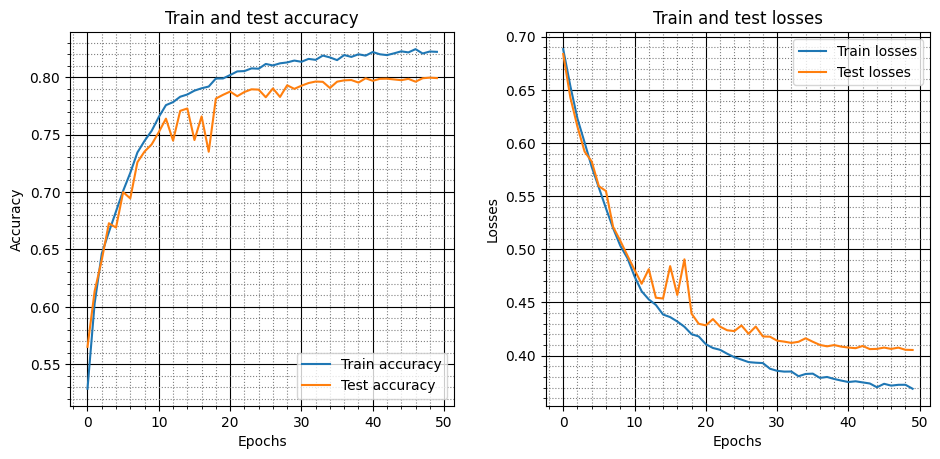

In [64]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
fig.tight_layout(pad=3.5)


axs[0].plot(train_accuracy, label="Train accuracy")
axs[0].plot(test_accuracy, label="Test accuracy")
axs[1].plot(train_losses, label="Train losses")
axs[1].plot(test_losses, label="Test losses")


axs[0].set_title(f"Train and test accuracy")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Accuracy")

axs[0].grid(which="major", color="k")

axs[0].minorticks_on()
axs[0].grid(which="minor", color="gray", linestyle=":")


axs[1].set_title(f"Train and test losses")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Losses")

axs[1].grid(which="major", color="k")

axs[1].minorticks_on()
axs[1].grid(which="minor", color="gray", linestyle=":")

axs[0].legend()
axs[1].legend()

По итогу модель показывает неплохую точность и на самый большой loss

В ходе проделанной работы мы познакомились с основами NLP и построили небольшую модель для классификации текста